# Exercise 08 - Size optimization for continua


## Task 1 - Book shelf

Let us consider a bookshelf that needs a support structure. The design domain is given by a unit square $x \in [0, 1]^2$ and a maximum thickness $d_{max}=0.1$. The left boundary of the domain $\partial \Omega_D$ is fixed to the wall and the top boundary $\partial \Omega_N$ is loaded with a uniform line load representing the weight of books.

![Four bar truss](https://meyer-nils.github.io/structural_optimization/figures/domain.png)


In [1]:
from math import sqrt

import torch
from torchfem import Planar
from torchfem.materials import IsotropicPlaneStress
from tqdm import tqdm

torch.set_default_dtype(torch.double)

The following code creates a planar FEM object called `square`. It uses a constant thickness of $d=0.1$ for the entire domain, forces $f(\mathbf{x}) = 1.0/N, \mathbf{x} \in \partial \Omega_N$ and the material parameters $E=1000.0, \nu=0.3$.

In [2]:
# Define Material
material = IsotropicPlaneStress(E=1000.0, nu=0.3)
print(material.C())

tensor([[1098.9011,  329.6703,    0.0000],
        [ 329.6703, 1098.9011,    0.0000],
        [   0.0000,    0.0000,  384.6154]])


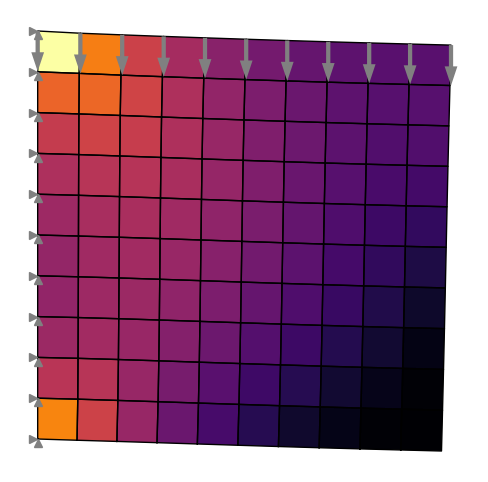

In [3]:
# Create nodes
N = 10
n1 = torch.linspace(0.0, 1, N + 1)
n2 = torch.linspace(0.0, 1, N + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(N):
    for i in range(N):
        n0 = i + j * (N + 1)
        elements.append([n0, n0 + 1, n0 + N + 2, n0 + N + 1])
elements = torch.tensor(elements)

# Create model
square = Planar(nodes, elements, material)

# Define masks for boundary conditions
top = nodes[:, 1] == 1.0
left = nodes[:, 0] == 0.0
right = nodes[:, 0] == 1.0
tip = top & right

# Load at top
square.forces[top, 1] = -1.0 / N
square.forces[tip, 1] = -0.5 / N

# Constrained displacement at left end
square.constraints[left, :] = True

# Thickness
square.thickness[:] = 0.1

# Solve the system
u, f = square.solve()

# Compute von Mises stress
mises = square.compute_stress(u, mises=True)

# Plot the result
square.plot(u=u, element_property=mises, cmap="inferno")

To save material, the bookshelf should use only 50% of that given design space, while being as stiff as possible to support many books. We want to achieve this by a variable thickness distribution of the component. 

You are provided with a function that performs root finding with the bisection method from a previous exercise. Now, you should implement a size optimization algorithm with MMA in a function named `optimize(fem, d_0, d_min, d_max, V_0, iter=15)` that takes the FEM model `fem`, the initial thickness distribution `d_0`, the minimum and maximum thickness distributions `d_min, d_max`, the volume constraint, and the maximum iteration count `iter` with a default value of 15.

a) Write a helper function `compute_areas(truss)` that computes the areas of the elements in the FEM object `truss`. The function should return a torch array with the areas of the elements. 
*Hints*: The variable `nodes` has the shape (Mx4x2), i.e the four ($x_1$, $x_2$) coordinates of the nodes of each element $j \in [0...M-1]$. The loop iterates over all integration points with weights `w` and positions `q`.

b) Add code that modifies the thickness according to the current design variables and solves the FEM problem in each iteration. *Hint*: You can overwrite `fem.thickness` to set the thickness of the FEM object.

c) Add the analytical solution for $d^*$. *Hint*: This is analogous to the truss problem.

d) Add the analytical solution for the gradient of the dual function w.r.t. $\mu$. *Hint*: This is analogous to the truss problem.

e) Solve the dual problem with bisection. 

f) Compute current optimal point with dual solution and append it to solutions. 

In [4]:
def bisection(f, a, b, max_iter=50, tol=1e-10):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c

In [5]:
def compute_areas(truss):
    areas = torch.zeros((truss.n_elem))
    nodes = truss.nodes[truss.elements, :]
    for w, q in zip(truss.etype.iweights(), truss.etype.ipoints()):
        # Compute the Jacobian
        J = truss.etype.B(q) @ nodes
        # Compute the determinant of the Jacobian
        detJ = torch.linalg.det(J)
        # Add the contribution of this integration point to the area
        areas += w * detJ
    return areas

In [6]:
def optimize(fem, d_0, d_min, d_max, V_0, iter=15):
    # Compute stiffness matrix without thickness factor
    k0 = torch.einsum("i,ijk->ijk", 1.0 / fem.thickness, fem.k())
    # List for thickness results and lower asymptotes
    d = [d_0]
    L = []
    # Element-wise areas
    areas = compute_areas(fem)
    # MMA parameter
    s = 0.7

    # Check if there is a feasible solution before starting iteration
    if torch.inner(d_min, areas) > V_0:
        raise Exception("d_min is not compatible with V_0.")

    # Iterate solutions
    for k in tqdm(range(iter)):
        # Solve the problem at d_k
        fem.thickness = d[k]
        u_k, f_k = fem.solve()

        # Compute strain energy density
        disp = u_k[fem.elements, :].reshape(fem.n_elem, -1)
        w_k = 0.5 * torch.einsum("...i,...ij,...j", disp, k0, disp)

        # Compute lower asymptote
        if k <= 1:
            L.append(d[k] - s * (d_max - d_min))
        else:
            L_k = torch.zeros_like(L[k - 1])
            osci = (d[k] - d[k - 1]) * (d[k - 1] - d[k - 2]) < 0.0
            L_k[osci] = d[k][osci] - s * (d[k - 1][osci] - L[k - 1][osci])
            L_k[~osci] = d[k][~osci] - 1 / sqrt(s) * (d[k - 1][~osci] - L[k - 1][~osci])
            L.append(L_k)

        # Compute lower move limit in this step
        d_min_k = torch.max(d_min, 0.9 * L[k] + 0.1 * d[k])

        # Analytical solution
        def d_star(mu):
            d_hat = L[k] + torch.sqrt((2.0 * w_k * (L[k] - d[k]) ** 2) / (mu * areas))
            return torch.clamp(d_hat, d_min_k, d_max)

        # Analytical gradient
        def grad(mu):
            return torch.dot(d_star(mu), areas) - V_0

        # Solve dual problem
        mu_star = bisection(grad, 1e-10, 100.0)

        # Compute current optimal point with dual solution
        d.append(d_star(mu_star))

    return d

g) Now run the optimization with $d_0=0.05, d_{min}=0.001, d_{max}=0.1$ and a volume constraint $V_0=50\%$ of the maximum design volume.

100%|██████████| 30/30 [00:00<00:00, 200.83it/s]


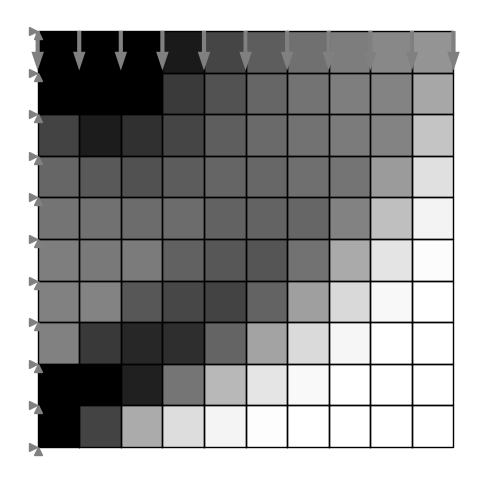

In [7]:
# Initial thickness, minimum thickness, maximum thickness
d_0 = 0.05 * torch.ones(len(square.elements))
d_min = 0.001 * torch.ones_like(d_0)
d_max = 0.1 * torch.ones_like(d_0)

# Initial volume (50% of maximum design volume)
areas = compute_areas(square)
V0 = 0.5 * torch.inner(d_max, areas)

# Optimize and visualize results
d_opt = optimize(square, d_0, d_min, d_max, V0, iter=30)
square.plot(element_property=d_opt[-1], cmap="gray_r")

h) Plot the evolution of design variables vs. iterations. What does the graph tell you?

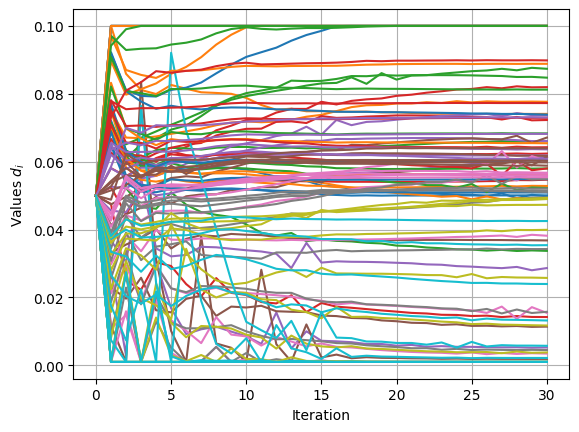

In [8]:
import matplotlib.pyplot as plt

plt.plot(torch.stack(d_opt).detach())
plt.xlabel("Iteration")
plt.ylabel("Values $d_i$")
plt.grid()

i) How do you interpret the design? Decide which manufacturing process you would like to use and use a CAD software to create a design based on your optimization. You may use the following code to get patches for different thickness sheets. You can build the optimal solution at home with cardboad by stacking the patches and gluing them together.

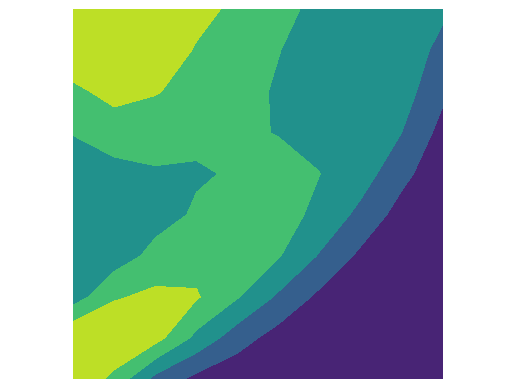

In [9]:
centers = square.nodes[square.elements].mean(dim=1)
plt.contourf(
    centers[:, 0].reshape(N, N),
    centers[:, 1].reshape(N, N),
    d_opt[-1].reshape(N, N),
    levels=4,
)
plt.axis("equal")
plt.axis("off")
plt.show()